In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

Using TensorFlow backend.


## Loading Dataset

Considering only more than 4 sec files and
labelling the files as Normal or Abnormal

In [2]:
dataset = []
for folder in ["./set_a/**","./set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            # skip audio smaller than 4 secs
            if librosa.get_duration(filename=filename)>=4:
                if label not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
                    if (label == "normal"):
                        dataset.append({
                            "filename": filename,
                            "label": "normal"
                        })
                    else:
                        dataset.append({
                            "filename": filename,
                            "label": "abnormal"
                        })
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)

TODO: Add artifacts (i.e. noises without heartbeat data) and ask the user to try again

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 193 to 102
Data columns (total 2 columns):
filename    364 non-null object
label       364 non-null object
dtypes: object(2)
memory usage: 8.5+ KB


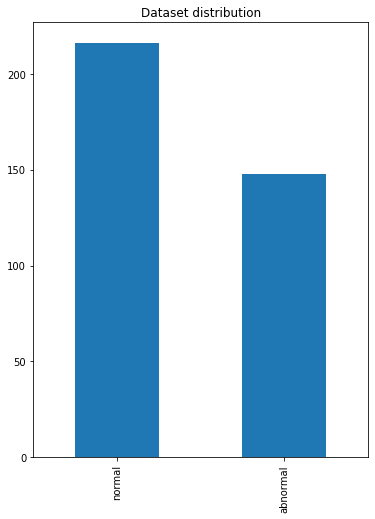

In [4]:
plt.figure(figsize=(6,8))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

## Split dataset in train and test
80-20 Ratio

In [5]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 291
Test: 73


## Extracting features

In [6]:
a = 33

./set_b/normal__137_1306764999211_C.wav
./set_b/murmur__116_1306258689913_D.wav


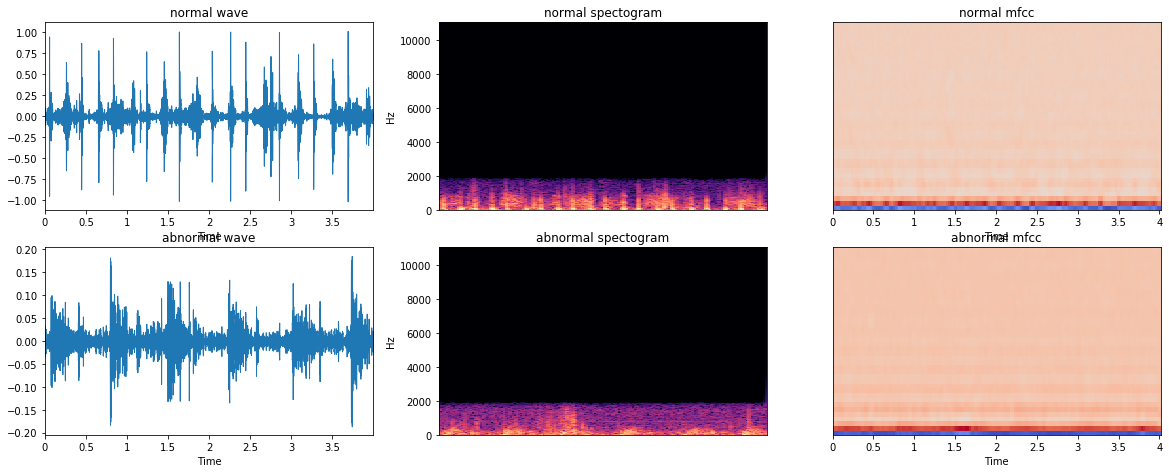

CPU times: user 3.68 s, sys: 63.9 ms, total: 3.75 s
Wall time: 1.45 s


In [7]:
%%time
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[a], duration=4)
    print(dataset[dataset.label==label].filename.iloc[a])
    idx+=1
    plt.subplot(5, 3, idx)
    plt.title("%s wave" % label)
    librosa.display.waveplot(y, sr=sr)
    idx+=1
    plt.subplot(5, 3, idx)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.title("%s spectogram" % label)
    idx+=1
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.subplot(5, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc" % label)
plt.show()

./set_b/normal__137_1306764999211_C.wav
./set_b/murmur__116_1306258689913_D.wav


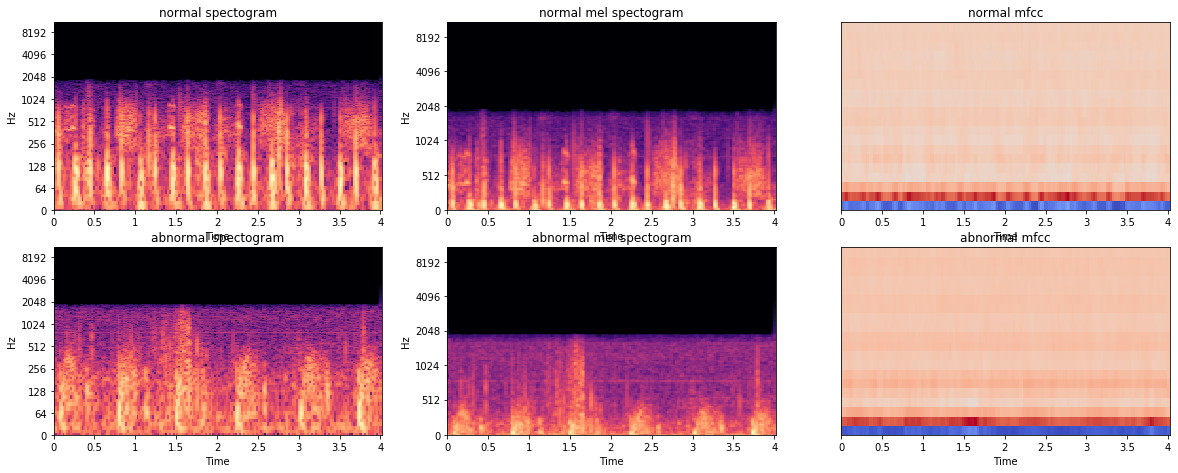

CPU times: user 4.87 s, sys: 54.7 ms, total: 4.92 s
Wall time: 1.02 s


In [13]:
%%time
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[a], duration=4)
    print(dataset[dataset.label==label].filename.iloc[a])
    idx+=1
    plt.subplot(5, 3, idx)
    plt.title("%s spectogram" % label)
#     librosa.display.waveplot(y, sr=sr)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=2048, hop_length=512)), ref=np.max)
    librosa.display.specshow(D,sr=sr,hop_length=512, x_axis='time', y_axis='log')
    idx+=1
    plt.subplot(5, 3, idx)
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
#     D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=2048, hop_length=512)), ref=np.max)
#     librosa.display.specshow(D, y_axis='linear')

    plt.title("%s mel spectogram" % label)
    idx+=1
#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S))
    plt.subplot(5, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc" % label)
plt.show()